In [3]:
from astropy.io import fits
import fitsio
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import numpy as np
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve2d
import sys
sys.path.append('../python/')
import chroma
reload(chroma)
from tqdm import tqdm
from astropy.modeling import models, fitting
from scipy.interpolate import RectBivariateSpline,interp2d
from scipy.optimize import minimize

In [2]:
psfdir='../psf_models/psf_data_8_18_08/PSF_Mono/'
module=2
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,module,module+channel))
psf_model=np.zeros((4,len(fnames),50,50))

for l in tqdm(xrange(len(fnames))):
    for j,channel in (enumerate([0.1,0.2,0.3,0.4])):
        h=sio.loadmat(fnames[0])
        psf=np.zeros((len(fnames),np.shape(h['psf'])[0],np.shape(h['psf'])[1]))
        res=h['grid_res'][0][0]
        lam=[]
        for i,f in enumerate(fnames):
            h=sio.loadmat(f)
            psf[i,:,:]=h['psf']
            lam.append(f.split('_')[-1][0:-4])

        PRFx = np.arange(0., np.shape(psf[0])[0] + 0.)-np.shape(psf[0])[0]/2
        PRFy = np.arange(0., np.shape(psf[0])[1] + 0.)-np.shape(psf[0])[0]/2
        PRFx*=0.03
        PRFy*=0.03
        PRFX,PRFY=np.meshgrid(PRFx,PRFy)    
        cx=PRFX[0][np.where(PRFX[0]>=0)[0][0]:np.where(PRFX[0]<1)[0][-1]]
        cy=PRFY[:,0][np.where(PRFY[:,0]>=0)[0][0]:np.where(PRFY[:,0]<1)[0][-1]]
        cx,cy=np.meshgrid(cx,cy)
        prf=np.copy(cx)*0.+1.
        psf_c=convolve2d(psf[l,:,:],prf,mode='same')

        psf_c/=np.nansum(psf_c)

        model=RectBivariateSpline(PRFx,PRFy,psf_c)
        X,Y=np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))

        PRFX,PRFY,psf_c=X,Y,model(X[0],Y[:,0])
        psf_model[j,l,:,:]=psf_c

NameError: name 'module' is not defined

In [287]:
pickle.dump(psf_model,open('psf_model.p','wb'))

In [4]:
psf_model=pickle.load(open('psf_model.p','rb'))
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(psf_model[3,11,:,:])
ax[0,1].imshow(psf_model[2,11,:,:])
ax[1,0].imshow(psf_model[1,11,:,:])
ax[1,1].imshow(psf_model[0,11,:,:])

NameError: name 'pickle' is not defined

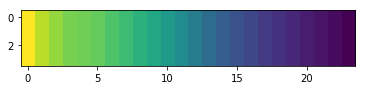

In [290]:
fit=fitting.LevMarLSQFitter()
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,module,module+channel))
psf_xshifts=np.zeros((np.shape(psf_model)[0],np.shape(psf_model)[1]))
psf_yshifts=np.zeros((np.shape(psf_model)[0],np.shape(psf_model)[1]))

for l in (xrange(len(fnames))):
    for j,channel in (enumerate([0.1,0.2,0.3,0.4])):
        g_init=models.Gaussian2D(x_mean=0,y_mean=0,amplitude=np.max(psf_model[j,l,:,:]))
        g=fit(g_init,PRFX,PRFY,psf_model[j,l,:,:])
        #plt.contourf(PRFX,PRFY,psf_model[j,l,:,:])
        #plt.scatter(g.x_mean.value,g.y_mean.value,c='C1')
        psf_xshifts[j,l],psf_yshifts[j,l]=g.x_mean.value,g.y_mean.value
        

In [360]:
def fitpsf(infile='../data/test1/blue_13.fits',plot=False):
    h=fits.open(infile)
    
        
    data = fitsio.read(infile,ext=1,columns='FLUX')
    frame=np.asarray(data[0])
    output=h[0].header['OUTPUT']
    x,y=np.arange(np.shape(frame)[0]),np.arange(np.shape(frame)[1])
    X,Y=np.meshgrid(x,y)
    

    def psf(vals,return_fit=False):
        model_x,model_y,model=np.copy(PRFX),np.copy(PRFY),np.copy(psf_model[output,int(vals[3]),:,:])
        model*=10.**(vals[0])
        model_x+=vals[1]+psf_xshifts[output,int(vals[3])]
        model_y+=vals[2]+psf_xshifts[output,int(vals[3])]
        f=RectBivariateSpline(model_x[0],model_y[:,0],model)   
        if return_fit==True:
            return model_x[0],model_y[:,0],f(model_x[0],model_y[:,0]),f(x,y)
        
        else:
            model_fit=f(x,y)
            chi=(1./float(len(model_fit.ravel())))*np.nansum((frame-model_fit)**2/(frame))**0.5
            return chi
        
        
        
   
    idx=np.unravel_index(np.nanargmax(frame),np.shape(frame))

    tot=np.nanmax(frame)
    initial_guess=[np.log10(tot/np.nanmax(psf_c)),idx[0],idx[1],11]
    fit=minimize(psf,initial_guess,bounds=[(np.log10(tot/np.nanmax(psf_model)),(np.log10(tot/np.nanmax(psf_model))+3)),
                                           (idx[0]-0.5,idx[0]+0.5),
                                           (idx[1]-0.5,idx[1]+0.5),
                                           (0,np.shape(psf_model)[1])],method='L-BFGS-B')
    
    vals=fit.x
    for l in xrange(np.shape(psf_model)[1]):
        model_x,model_y,model=np.copy(PRFX),np.copy(PRFY),np.copy(psf_model[output,l,:,:])
        model*=10.**(vals[0])
        model_x+=vals[1]+psf_xshifts[output,l]
        model_y+=vals[2]+psf_xshifts[output,l]
        f=RectBivariateSpline(model_x[0],model_y[:,0],model)   
        plt.scatter(l,np.nanmedian(f(x,y)-frame))

    
    if plot==True:
        plt.figure()
        scaled_x,scaled_y,model_fit,model_fit_2=psf(fit.x,return_fit=True)
        _=plt.plot((np.meshgrid(scaled_x,scaled_y)[0]).T,model_fit.T,c='C1',alpha=0.1)
        _=plt.scatter(np.meshgrid(x,y)[0],frame.T,c='C0')
        _=plt.scatter(np.meshgrid(x,y)[0],model_fit_2.T,c='C1',alpha=0.3)
        plt.figure()
        plt.contourf(np.meshgrid(x,y)[0],np.meshgrid(x,y)[1],frame.T)
        _=plt.contour(np.meshgrid(scaled_x,scaled_y)[0],np.meshgrid(scaled_x,scaled_y)[1],model_fit.T,colors='white',alpha=0.3)
        plt.scatter(idx[0],idx[1],c='C1')
    return fit.x
    


In [ ]:
fnames=glob('/Users/christina/Desktop/chromaTPFs_2/*.fits')
fitpsf(fnames[108],plot=True)

array([  8.43034023,   3.5       ,   3.5       ,  11.        ])

In [129]:
def measurepsf(infile='../data/test1/blue_13.fits'):
    h=fits.open(infile)
    if isinstance(h[0].header['GRCOLOR'],float)==False:
        gr=-99
    else:
        gr=h[0].header['GRCOLOR']
    if isinstance(h[0].header['GMAG'],float)==False:
        gmag=-99
    else:
        gmag=h[0].header['GMAG']
    if isinstance(h[0].header['IMAG'],float)==False:
        imag=-99
    else:
        imag=h[0].header['IMAG']
        
        
    data = fitsio.read(infile,ext=1,columns='FLUX')
    frame=data[0]
    def psf(vals,return_fit=False):
        model_x,model_y,model=np.copy(PRFX),np.copy(PRFY),np.copy(psf_c)
        model*=10.**(vals[0])
        scaled_x=(model_x[0]-np.mean(model_x[0]))*vals[3]
        scaled_x-=(np.mean(scaled_x)-vals[1])
        if np.nansum(scaled_x)==0:
            return 9999
        scaled_y=(model_y[:,0]-np.mean(model_y[:,0]))*vals[4]
        scaled_y-=(np.mean(scaled_y)-vals[2])
        if np.nansum(scaled_y)==0:
            return 9999


        f=RectBivariateSpline(scaled_x,scaled_y,model)   
        if return_fit==True:
            return scaled_x,scaled_y,f(scaled_x,scaled_y),f(x,y)


    #    _=plt.contour(np.meshgrid(scaled_x,scaled_y)[0],np.meshgrid(scaled_x,scaled_y)[1],f(scaled_x,scaled_y),colors='white')
        
        else:
            model_fit=f(x,y)
            chi=(1./float(len(model_fit.ravel())))*np.nansum((frame-model_fit)**2/(frame))**0.5
            return chi
    
    
    x,y=np.arange(len(frame)),np.arange(len(frame.T))
    idx=np.unravel_index(np.nanargmax(frame),np.shape(frame))
    tot=np.nanmax(frame)
    initial_guess=[np.log10(tot/np.nanmax(psf_c)),idx[0],idx[1],1.,1.]

    fit=minimize(psf,initial_guess,bounds=[(5,11),(0,len(x)),(0,len(y)),(0.5,1.5),(0.5,1.5)])
#    scaled_x,scaled_y,model_fit,model_fit_2=psf(fit.x,return_fit=True)
#    _=plt.plot((np.meshgrid(scaled_x,scaled_y)[0]).T,model_fit.T,c='C1',alpha=0.1)
#    _=plt.scatter(np.meshgrid(x,y)[0],frame.T,c='C0')
#    _=plt.scatter(np.meshgrid(x,y)[0],model_fit_2.T,c='C1')

    
    result={'xstretch':fit.x[3],'ystretch':fit.x[4],'tot':tot,'gr':gr,'gi':gmag-imag}
    return result

In [22]:
import pickle
r=pickle.load(open("measured_psfs_module13.p","rb"))

In [89]:
fnames=glob('/Users/christina/Desktop/chromaTPFs_2/*.fits')
for f in fnames:
    h=fits.open(f)
    s=np.shape(h[1].data['FLUX'])
    if s[1]-s[2]==2:
        break
print f

/Users/christina/Desktop/chromaTPFs_2/kplr011958062-2011073133259_lpd-targ.fits


In [23]:
fnames=glob('/Users/christina/Desktop/chromaTPFs_2/*.fits')
r=[]
for f in tqdm(fnames):
    r.append(measurepsf(f))  

100%|██████████| 292/292 [00:31<00:00,  9.36it/s]


In [24]:
xs,ys,gr,gi,tot=[],[],[],[],[]
for i in r:
    xs.append(i['xstretch'])
    ys.append(i['ystretch'])
    gr.append(i['gr'])
    gi.append(i['gi'])
    tot.append(i['tot'])
xs=np.asarray(xs)
ys=np.asarray(ys)
gr=np.asarray(gr)
gi=np.asarray(gi)
tot=np.asarray(tot)

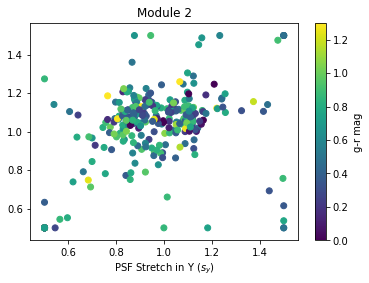

In [25]:
pos=(gr>-50)&(gr<50)
plt.scatter(xs[pos],ys[pos],c=gr[pos],vmin=0.,vmax=1.3)
cbar=plt.colorbar()
cbar.set_label('g-r mag')
plt.xlabel('PSF Stretch in X ($s_x$)')
plt.xlabel('PSF Stretch in Y ($s_y$)')
plt.title('Module 2')
plt.savefig('../images/gr_2.png',bbox_inches='tight',dpi=150)

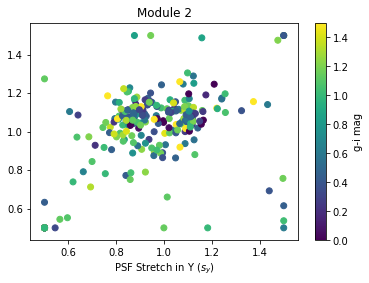

In [26]:
pos=(gi>-50)&(gi<50)
plt.scatter(xs[pos],ys[pos],c=gi[pos],vmin=0.,vmax=1.5)
cbar=plt.colorbar()
cbar.set_label('g-i mag')
plt.xlabel('PSF Stretch in X ($s_x$)')
plt.xlabel('PSF Stretch in Y ($s_y$)')
plt.title('Module 2')
plt.savefig('../images/gi_2.png',bbox_inches='tight',dpi=150)

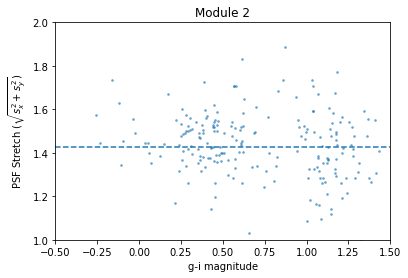

In [27]:
pos=(gi>-50)&(gi<50)&(gr>-50)&(gr<50)
plt.scatter(gi[pos],(xs[pos]**2+ys[pos]**2)**0.5,alpha=0.5,s=3)
plt.ylim(1,2)
plt.xlim(-0.5,1.5)
plt.ylabel('PSF Stretch ($\sqrt{s_x^2+s_y^2}$)')
plt.xlabel('g-i magnitude')
plt.title('Module 2')
plt.axhline(np.median((xs[pos]**2+ys[pos]**2)**0.5),ls='--')
plt.savefig('../images/gi2_2.png',bbox_inches='tight',dpi=150)

['../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_430.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_450.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_470.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_490.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_510.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_530.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_550.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_570.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_590.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_610.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_630.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_650.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_670.mat',
 '../psf_models/psf_data_8_18_08/PSF_Mono/Module_2/2.4/Mod2_4_69